# Problem Name: House Prices: Advanced Regression Techniques

### Problem Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [127]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [128]:
train=pd.read_csv('train.csv')
train.shape

(1460, 81)

In [129]:
test=pd.read_csv('test.csv')
test.shape

(1459, 80)

In [130]:
train.head().T

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65.0,80.0,68.0,60.0,84.0
LotArea,8450,9600,11250,9550,14260
...,...,...,...,...,...
MoSold,2,5,9,2,12
YrSold,2008,2007,2008,2006,2008
SaleType,WD,WD,WD,WD,WD
SaleCondition,Normal,Normal,Normal,Abnorml,Normal


In [131]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Data Cleaning

In [132]:
train.drop(columns=['Id'],inplace=True)

In [133]:
columns_with_miss=train.isna().sum()
columns_with_miss=columns_with_miss[columns_with_miss!=0]
print('Columns With Missing Values',len(columns_with_miss))
columns_with_miss.sort_values(ascending=False)

Columns With Missing Values 19


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [134]:
train.drop(columns=['PoolQC','MiscFeature','Alley','Fence'],inplace=True)

In [135]:
train['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [136]:
train['FireplaceQu'].fillna(0, inplace=True)
train['FireplaceQu'].replace({'Po': 1, 'Fa': 2,'TA': 3, 'Gd': 4, 'Ex': 5}, inplace=True)

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

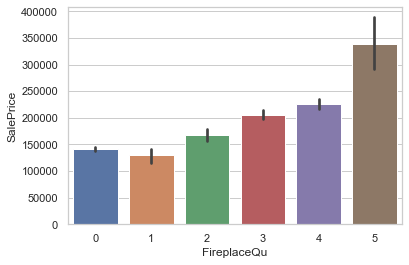

In [137]:
sns.set(style="whitegrid")
sns.barplot(x='FireplaceQu',y='SalePrice',data=train)

<AxesSubplot:>

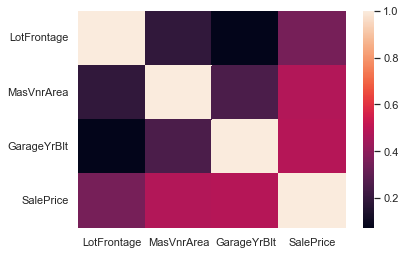

In [138]:
columns_with_miss=train.isna().sum()
columns_with_miss=columns_with_miss[columns_with_miss!=0]
c=list(columns_with_miss.index)
c.append('SalePrice')
train[c].corr()
sns.heatmap(data=train[c].corr(),cbar=True)

The above features are also not having strong correlations with SalesPrice

In [139]:
cols_to_remove=['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
train.drop(columns=cols_to_remove,inplace=True)

In [140]:
train.shape

(1460, 73)

In [141]:
for c in ['GarageType', 'GarageFinish', 'BsmtFinType2','BsmtExposure', 'BsmtFinType1']:
    train[c].fillna('NA',inplace=True)

In [142]:
train['MasVnrType'].fillna('None', inplace=True)

In [143]:
columns_with_miss = train.isna().sum()
columns_with_miss = columns_with_miss[columns_with_miss!=0]
print(f'Columns with missing values: {len(columns_with_miss)}')
columns_with_miss.sort_values(ascending=False)

Columns with missing values: 5


GarageQual    81
GarageCond    81
BsmtQual      37
BsmtCond      37
Electrical     1
dtype: int64

Categorical Values

In [144]:
# train.select_dtypes(include=['object'])
train.select_dtypes(include=['object']).nunique().sort_values(ascending=True)

Street            2
Utilities         2
CentralAir        2
PavedDrive        3
LandSlope         3
GarageFinish      4
MasVnrType        4
BsmtCond          4
KitchenQual       4
BsmtQual          4
LandContour       4
LotShape          4
ExterQual         4
GarageQual        5
Electrical        5
GarageCond        5
HeatingQC         5
BsmtExposure      5
MSZoning          5
ExterCond         5
LotConfig         5
BldgType          5
SaleCondition     6
Heating           6
RoofStyle         6
Foundation        6
BsmtFinType1      7
BsmtFinType2      7
GarageType        7
Functional        7
Condition2        8
HouseStyle        8
RoofMatl          8
Condition1        9
SaleType          9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

In [145]:
ord_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
            'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
for col in ord_cols:
    train[col].fillna(0, inplace=True) # Filling missing value
    train[col].replace({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4,
                        'Ex': 5}, inplace=True)

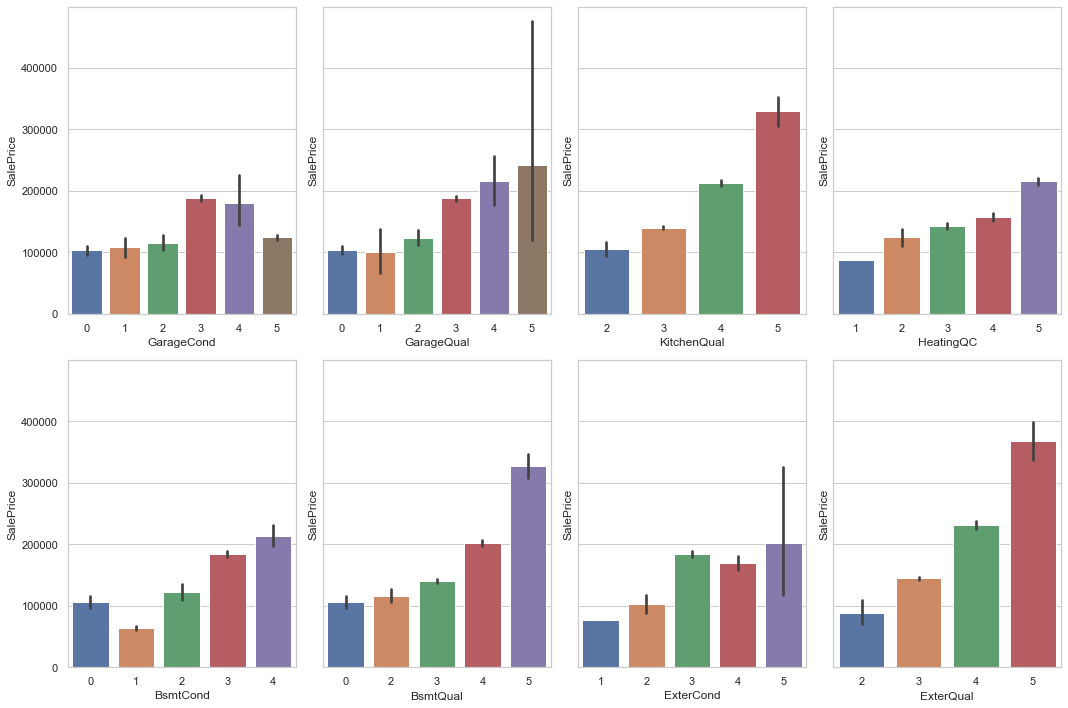

In [146]:
ord_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
            'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
f, axes = plt.subplots(2, 4, figsize=(15, 10), sharey=True)

for r in range(0, 2):
    for c in range(0, 4):
        sns.barplot(x=ord_cols.pop(), y="SalePrice",
                    data=train, ax=axes[r][c])

plt.tight_layout()
plt.show()

#### Nomial

In [147]:
cols = train.columns
num_cols = train._get_numeric_data().columns
nom_cols = list(set(cols) - set(num_cols))
print(f'Nominal columns: {len(nom_cols)}')

value_counts = {}
for c in nom_cols:
    value_counts[c] = len(train[c].value_counts())

sorted_value_counts = {k: v for k, v in \
sorted(value_counts.items(), key=lambda item: item[1])}

Nominal columns: 30


In [148]:
nom_cols_less_than_6 = []
for c in nom_cols:
    n_values = len(train[c].value_counts())
    if n_values < 7:
        nom_cols_less_than_6.append(c)

print(f'Nominal columns with less than 6 values: \
{len(nom_cols_less_than_6)}')

Nominal columns with less than 6 values: 18


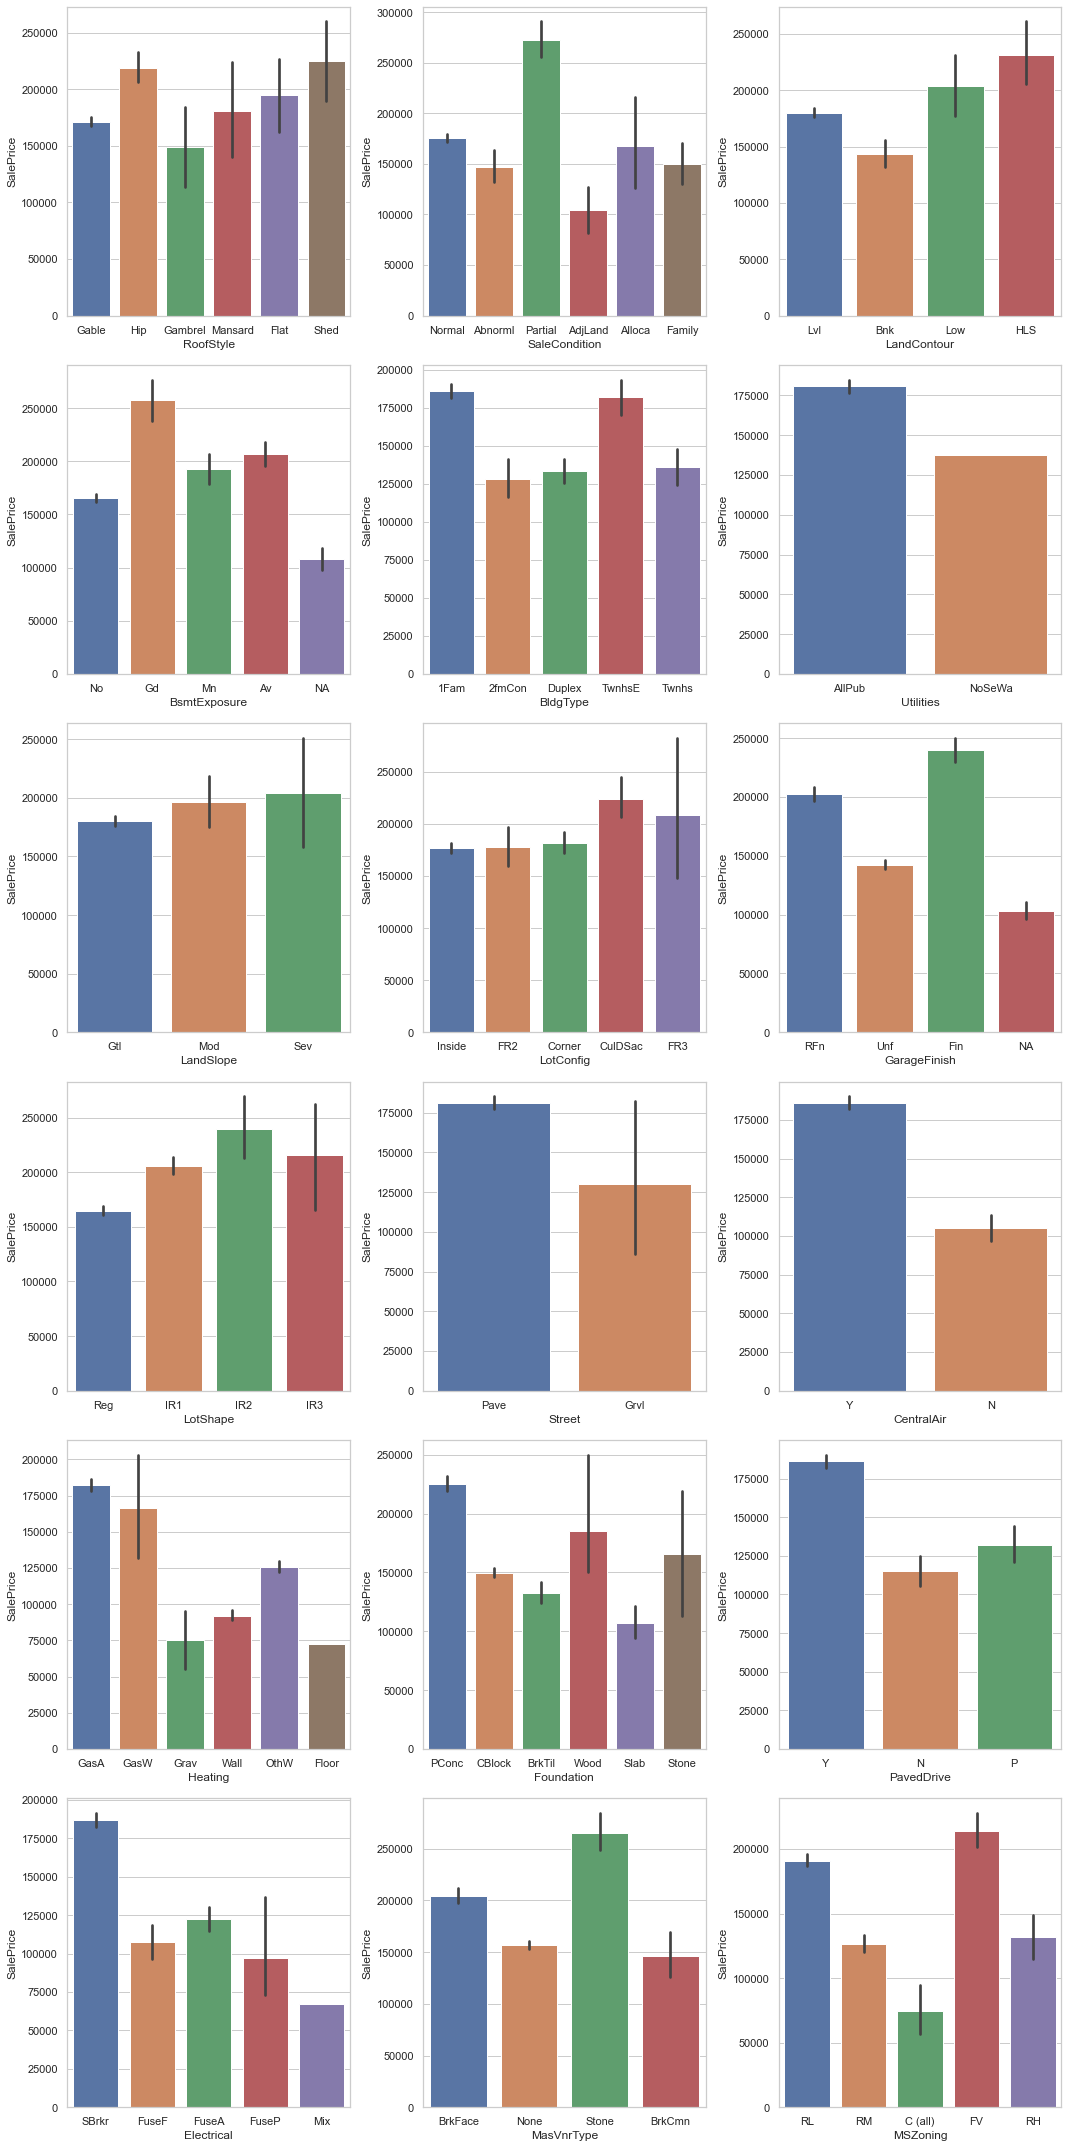

In [149]:
ncols = 3
nrows = math.ceil(len(nom_cols_less_than_6) / ncols)
f, axes = plt.subplots(nrows, ncols, figsize=(15, 30))

for r in range(0, nrows):
    for c in range(0, ncols):
        if not nom_cols_less_than_6:
            continue
        sns.barplot(x=nom_cols_less_than_6.pop(),
                    y="SalePrice", data=train, ax=axes[r][c])

plt.tight_layout()
plt.show()

In [150]:
train['Electrical'].fillna('SBrkr', inplace=True)

In [151]:
train['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

In [152]:
train.select_dtypes(include=['object']).nunique().sum()

203

In [153]:
train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [154]:
X=train.iloc[:,:-1].values
X

array([[60, 'RL', 8450, ..., 2008, 'WD', 'Normal'],
       [20, 'RL', 9600, ..., 2007, 'WD', 'Normal'],
       [60, 'RL', 11250, ..., 2008, 'WD', 'Normal'],
       ...,
       [70, 'RL', 9042, ..., 2010, 'WD', 'Normal'],
       [20, 'RL', 9717, ..., 2010, 'WD', 'Normal'],
       [20, 'RL', 9937, ..., 2008, 'WD', 'Normal']], dtype=object)

In [155]:
import os
def clean_data(df, output_file='cleaned_data.csv'):

    # Removes columns with missing values issues
    cols_to_be_removed = ['Id', 'PoolQC', 'MiscFeature',
                          'Alley', 'Fence', 'LotFrontage',
                          'GarageYrBlt', 'MasVnrArea']
    df.drop(columns=cols_to_be_removed, inplace=True)

    # Transforms ordinal columns to numerical
    ordinal_cols = ['FireplaceQu', 'ExterQual', 'ExterCond',
                    'BsmtQual', 'BsmtCond',
                    'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
    for col in ordinal_cols:
        df[col].fillna(0, inplace=True)
        df[col].replace({'Po': 1, 'Fa': 2, 'TA': 3,
                         'Gd': 4, 'Ex': 5}, inplace=True)

    # Replace the NaN with NA
    for c in ['GarageType', 'GarageFinish',
              'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1']:
        df[c].fillna('NA', inplace=True)

    # Replace the NaN with None
    df['MasVnrType'].fillna('None', inplace=True)

    # Imputes with most frequent value
    df['Electrical'].fillna('SBrkr', inplace=True)

    # Saves a copy
    cleaned_data = os.path.join(output_file)
    df.to_csv(cleaned_data)

    return df

In [156]:
test=clean_data(test)

Training Model

In [157]:
Dataset= pd.concat([train.drop(['SalePrice'],axis=1),test],axis=0)

In [158]:
def category_onehot_multcols(multcolumns):
    df_final=Dataset
    i=0
    for fields in multcolumns:

        print(fields)
        df1=pd.get_dummies(Dataset[fields],drop_first=True)

        Dataset.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1

    df_final=pd.concat([Dataset,df_final],axis=1)
    return df_final
## passing our total Dataframe for one hot encoder
Dataset=category_onehot_multcols(sorted_value_counts)
save_cols=Dataset.columns

CentralAir
Street
Utilities
PavedDrive
LandSlope
MasVnrType
LotShape
GarageFinish
LandContour
MSZoning
Electrical
LotConfig
BldgType
BsmtExposure
Foundation
Heating
SaleCondition
RoofStyle
BsmtFinType1
Functional
BsmtFinType2
GarageType
Condition2
RoofMatl
HouseStyle
Condition1
SaleType
Exterior1st
Exterior2nd
Neighborhood


In [159]:
Dataset.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,60,8450,7,5,2003,2003,4,3,4,3,...,0,0,0,0,0,0,0,0,0,0
1,20,9600,6,8,1976,1976,3,3,4,3,...,0,0,0,0,0,0,0,0,0,1
2,60,11250,7,5,2001,2002,4,3,4,3,...,0,0,0,0,0,0,0,0,0,0
3,70,9550,7,5,1915,1970,3,3,3,4,...,0,0,0,0,0,0,0,0,0,0
4,60,14260,8,5,2000,2000,4,3,4,3,...,1,0,0,0,0,0,0,0,0,0


In [160]:
from sklearn.preprocessing import StandardScaler
x = Dataset.values
x = StandardScaler().fit_transform(x)
x=pd.DataFrame(x,columns=save_cols)


In [161]:
train_data = x.iloc[:1460]
test_data =x.iloc[1460:]

In [162]:
train_data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,0.067331,-0.217879,0.646183,-0.507284,1.046258,0.896833,1.039805,-0.230047,0.577094,0.141836,...,-0.157892,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,-0.133351,-0.159028,-0.091050
1,-0.873616,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.683756,-0.230047,0.577094,0.141836,...,-0.157892,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,-0.133351,-0.159028,10.982941
2,0.067331,0.137197,0.646183,-0.507284,0.980221,0.848965,1.039805,-0.230047,0.577094,0.141836,...,-0.157892,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,-0.133351,-0.159028,-0.091050
3,0.302568,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.683756,-0.230047,-0.527521,1.881417,...,-0.157892,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,-0.133351,-0.159028,-0.091050
4,0.067331,0.518903,1.355551,-0.507284,0.947203,0.753229,1.039805,-0.230047,0.577094,0.141836,...,6.333457,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,-0.133351,-0.159028,-0.091050


In [163]:
test_data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
1460,-0.873616,0.184371,-0.772552,0.391237,-0.340510,-1.113625,-0.683756,-0.230047,-0.527521,0.141836,...,-0.157892,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,-0.133351,-0.159028,-0.09105
1461,-0.873616,0.519791,-0.063185,0.391237,-0.439565,-1.257229,-0.683756,-0.230047,-0.527521,0.141836,...,-0.157892,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,-0.133351,-0.159028,-0.09105
1462,0.067331,0.464374,-0.772552,-0.507284,0.848148,0.657493,-0.683756,-0.230047,0.577094,0.141836,...,-0.157892,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,-0.133351,-0.159028,-0.09105
1463,0.067331,-0.024109,-0.063185,0.391237,0.881166,0.657493,-0.683756,-0.230047,-0.527521,0.141836,...,-0.157892,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,-0.133351,-0.159028,-0.09105
1464,1.478753,-0.654748,1.355551,-0.507284,0.683057,0.370284,1.039805,-0.230047,0.577094,0.141836,...,-0.157892,-0.245556,-0.298629,-0.129302,-0.233564,-0.211515,-0.257869,7.499020,-0.159028,-0.09105


In [164]:
y = train['SalePrice'].values
sc=StandardScaler()
y = pd.DataFrame(sc.fit_transform(y.reshape(-1,1)))
y.columns=['SalePrice']
train_data = pd.concat([train_data,y],axis=1)

In [165]:
import matplotlib.pyplot as plt
from scipy.stats import norm

interested_col=[]

for item in train_data.corr().reset_index()[['index','SalePrice']].values:
    if item[1:2]>=0.15 or item[1:2]<=-0.15:
        interested_col.append(item[0:1][0])

interested_col.remove('SalePrice')
print(interested_col)

['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'Y', 'Y', 'BrkFace', 'None', 'Stone', 'Reg', 'NA', 'RFn', 'Unf', 'RL', 'RM', 'SBrkr', 'Gd', 'NA', 'No', 'CBlock', 'PConc', 'Normal', 'Partial', 'Gable', 'Hip', 'GLQ', 'NA', 'Attchd', 'BuiltIn', 'Detchd', 'NA', 'WdShngl', '2Story', 'New', 'WD', 'MetalSd', 'VinylSd', 'Wd Sdng', 'MetalSd', 'VinylSd', 'Wd Sdng', 'Edwards', 'IDOTRR', 'NAmes', 'NoRidge', 'NridgHt', 'OldTown', 'StoneBr']


In [166]:
columns=interested_col

In [177]:
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=train_data[columns],label=y)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 1000)

xg_reg.fit(train_data[columns],y)

y_pred = xg_reg.predict(test_data[columns])

ValueError: feature_names must be unique

In [175]:
pred=pd.DataFrame(sc.inverse_transform(y_pred))
sub_df=pd.read_csv('sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']

datasets.isnull()
datasets.to_csv('sample_submission.csv',index=False)

datasets

NameError: name 'y_pred' is not defined